## Setup Kaggle

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"ll0406","key":"fa4830570075c294db90b927a8ca9fe8"}') 
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73272 sha256=d2a63f85998d349fc52b0425220d2f413fc12b1785d98b7e80509407ce9e1afc
  Stored in directory: /root/.cache/pip/wheels/d4/02/ef/3f8c8d86b8d5388a1d3155876837f1a1a3143ab3fc2ff1ffad
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13


## Import Data from M5

In [2]:
!kaggle competitions download -c m5-forecasting-accuracy
!mkdir '/content/data'

!unzip -qo 'm5-forecasting-accuracy.zip' -d '/content/data'

 96% 44.0M/45.8M [00:03<00:00, 26.8MB/s]
100% 45.8M/45.8M [00:03<00:00, 14.9MB/s]


## Import Libraries

In [3]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [4]:
INPUT_DIR = './data'
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')

## Sample data and data snippet

In [5]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[2]].set_index('id')[d_cols].values[0]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[1]].set_index('id')[d_cols].values[0]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[17]].set_index('id')[d_cols].values[0]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales")
fig.show()

In [6]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[0]].set_index('id')[d_cols].values[0][:90]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[4]].set_index('id')[d_cols].values[0][1300:1400]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[65]].set_index('id')[d_cols].values[0][350:450]
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales snippets")
fig.show()

## Denoise the time series

### Wavelet denoising

Wavelet denoising (usually used with electric signals) is a way to remove the unnecessary noise from a time series. This method calculates coefficients called the "wavelet coefficients". These coefficients decide which pieces of information to keep (signal) and which ones to discard (noise).

We make use of the MAD (mean absolute deviation) value to understand the randomness in the sales and accordingly decide the minimum threshold for the wavelet coefficients in the time series. We filter out the low coefficients from the wavelets and reconstruct the sales data from the remaining coefficients and that's it; we have successfully removed noise from the sales data.

In [7]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

In [8]:
y_w1 = denoise_signal(x_1)
y_w2 = denoise_signal(x_2)
y_w3 = denoise_signal(x_3)


fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="mediumaquamarine"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), y=y_w1, mode='lines', marker=dict(color="darkgreen"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), mode='lines+markers', y=x_2, marker=dict(color="thistle"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), y=y_w2, mode='lines', marker=dict(color="purple"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="lightskyblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), y=y_w3, mode='lines', marker=dict(color="navy"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) sales")
fig.show()

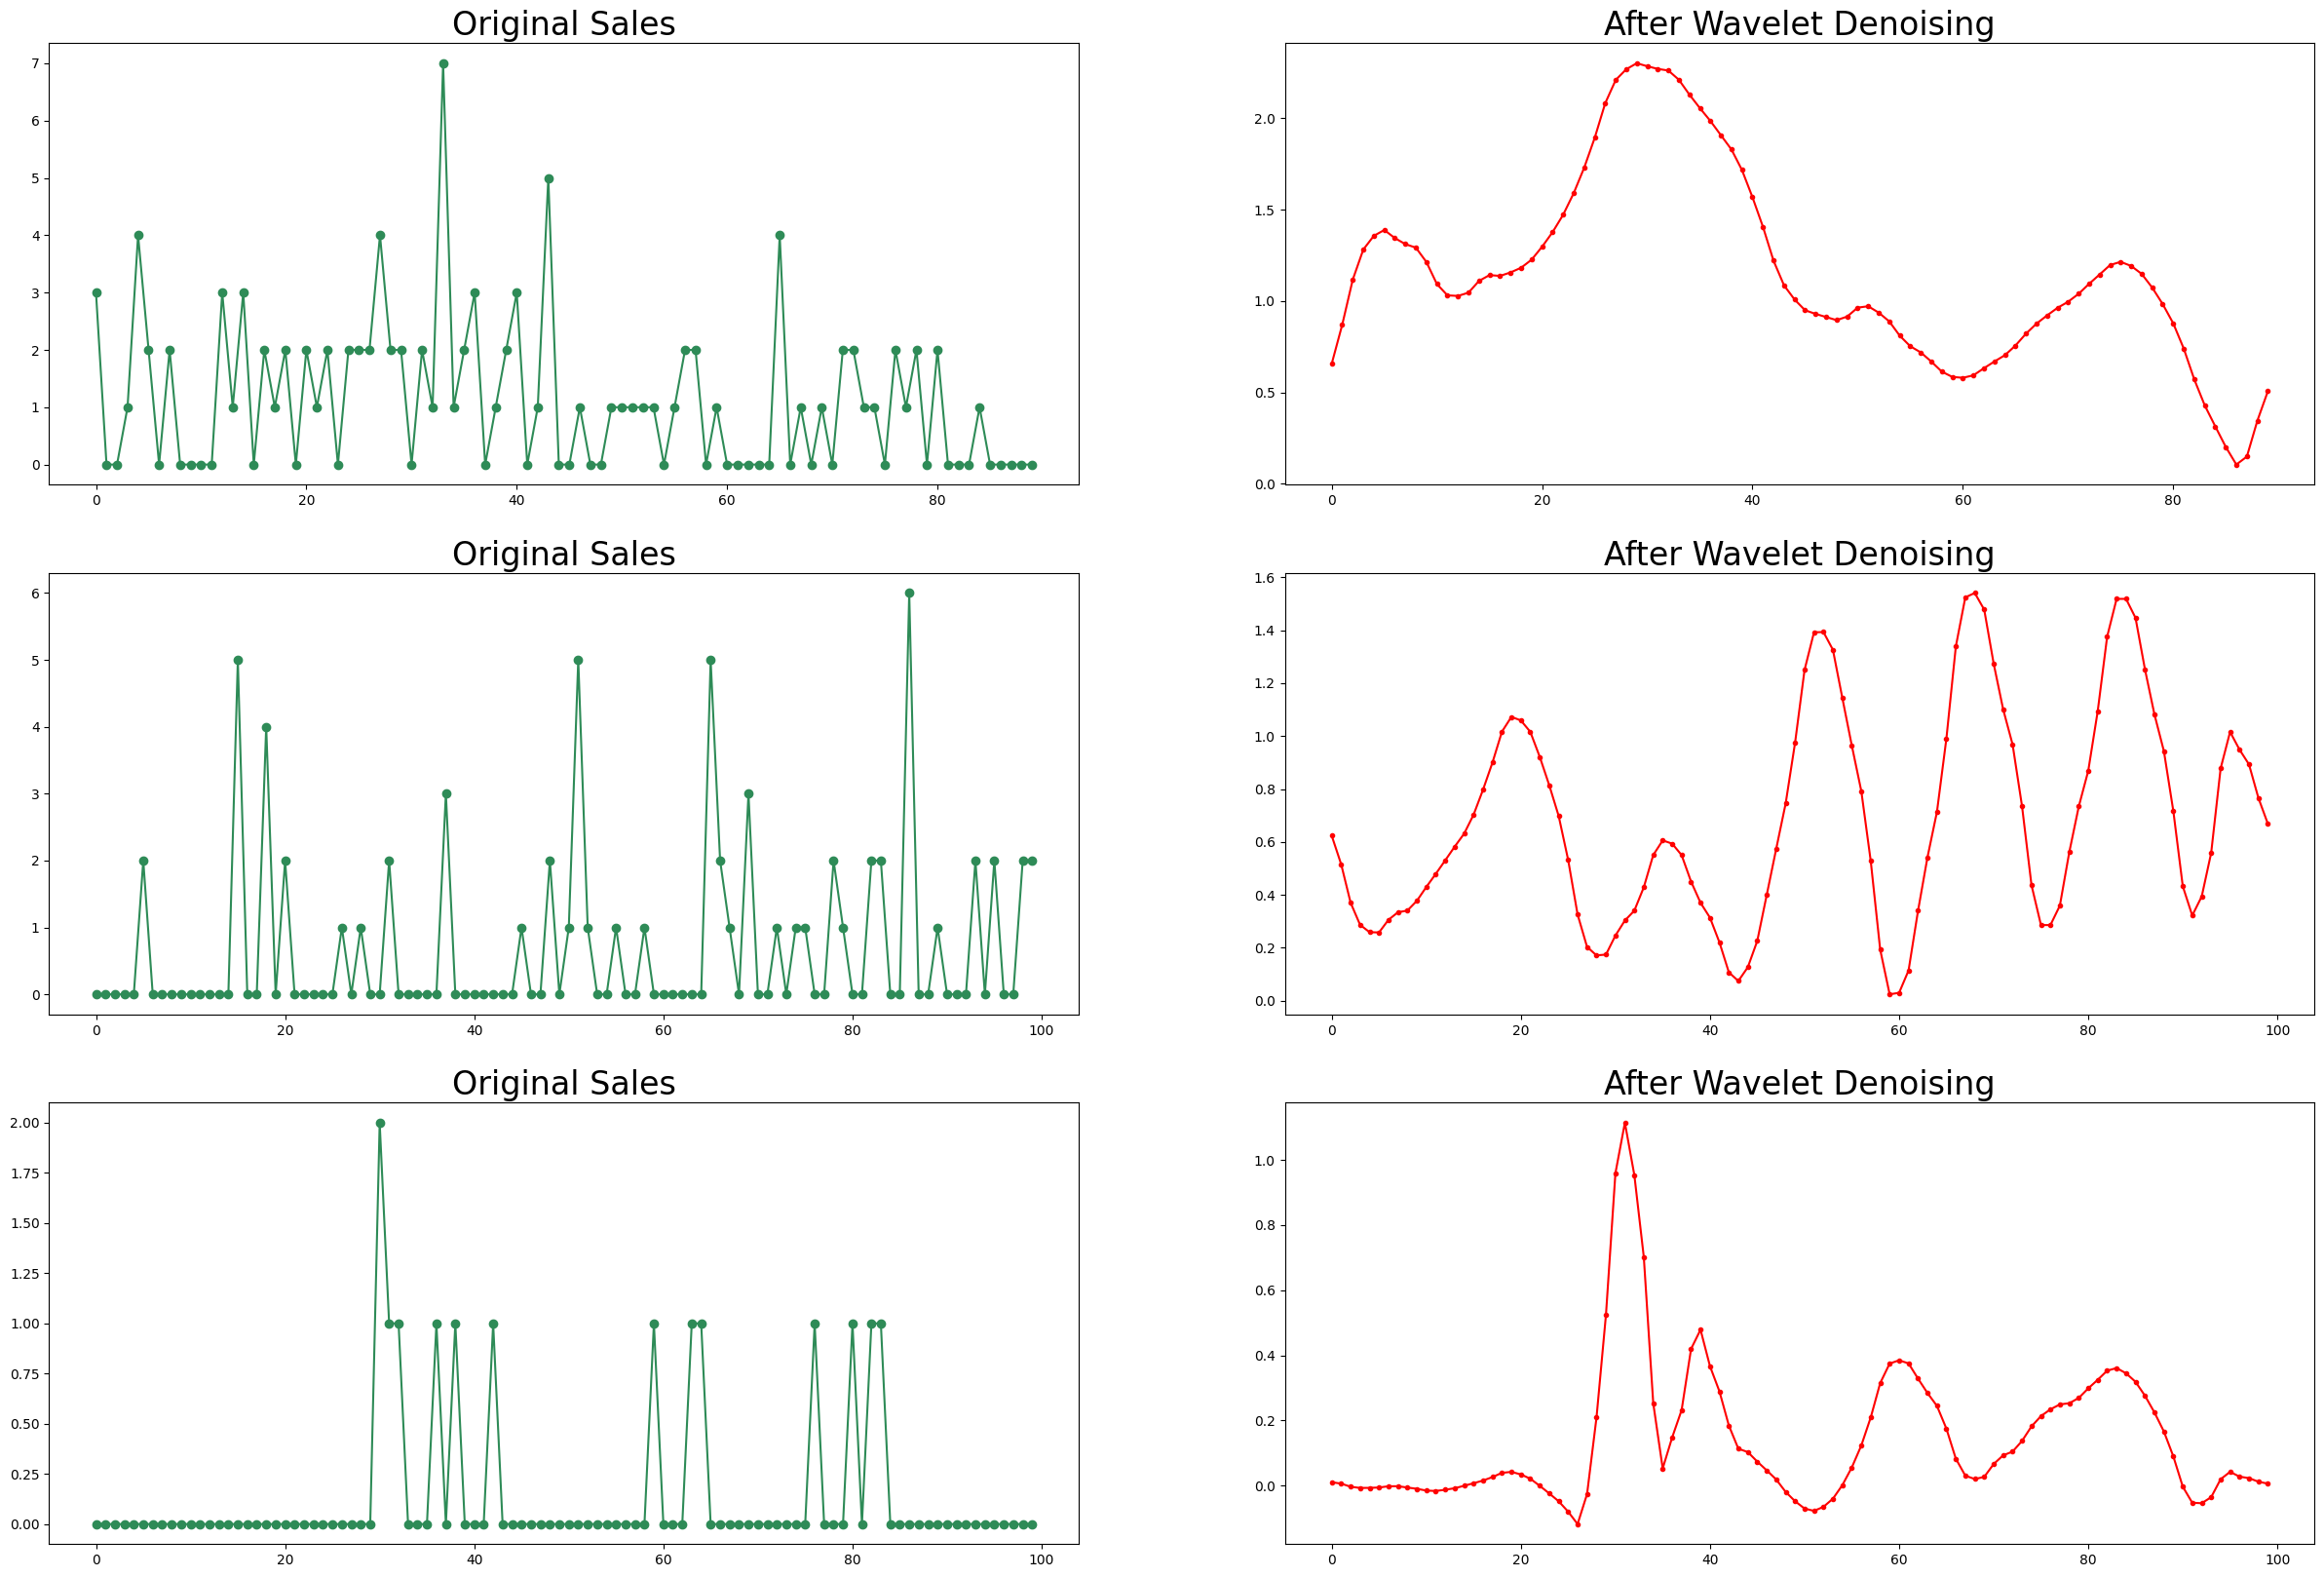

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

ax[0, 0].plot(x_1, color='seagreen', marker='o') 
ax[0, 0].set_title('Original Sales', fontsize=24)
ax[0, 1].plot(y_w1, color='red', marker='.') 
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[1, 0].plot(x_2, color='seagreen', marker='o') 
ax[1, 0].set_title('Original Sales', fontsize=24)
ax[1, 1].plot(y_w2, color='red', marker='.') 
ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[2, 0].plot(x_3, color='seagreen', marker='o') 
ax[2, 0].set_title('Original Sales', fontsize=24)
ax[2, 1].plot(y_w3, color='red', marker='.') 
ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)

plt.show()

### Average smoothing

Average smooting is a relatively simple way to denoise time series data. In this method, we take a "window" with a fixed size (like 10). We first place the window at the beginning of the time series (first ten elements) and calculate the mean of that section. We now move the window across the time series in the forward direction by a particular "stride", calculate the mean of the new window and repeat the process, until we reach the end of the time series. All the mean values we calculated are then concatenated into a new time series, which forms the denoised sales data.

In [10]:
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample)

In [11]:
y_a1 = average_smoothing(x_1)
y_a2 = average_smoothing(x_2)
y_a3 = average_smoothing(x_3)

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="lightskyblue"), showlegend=False,
               name="Original sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), y=y_a1, mode='lines', marker=dict(color="navy"), showlegend=False,
               name="Denoised sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), mode='lines+markers', y=x_2, marker=dict(color="thistle"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), y=y_a2, mode='lines', marker=dict(color="indigo"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="mediumaquamarine"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), y=y_a3, mode='lines', marker=dict(color="darkgreen"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) signals")
fig.show()

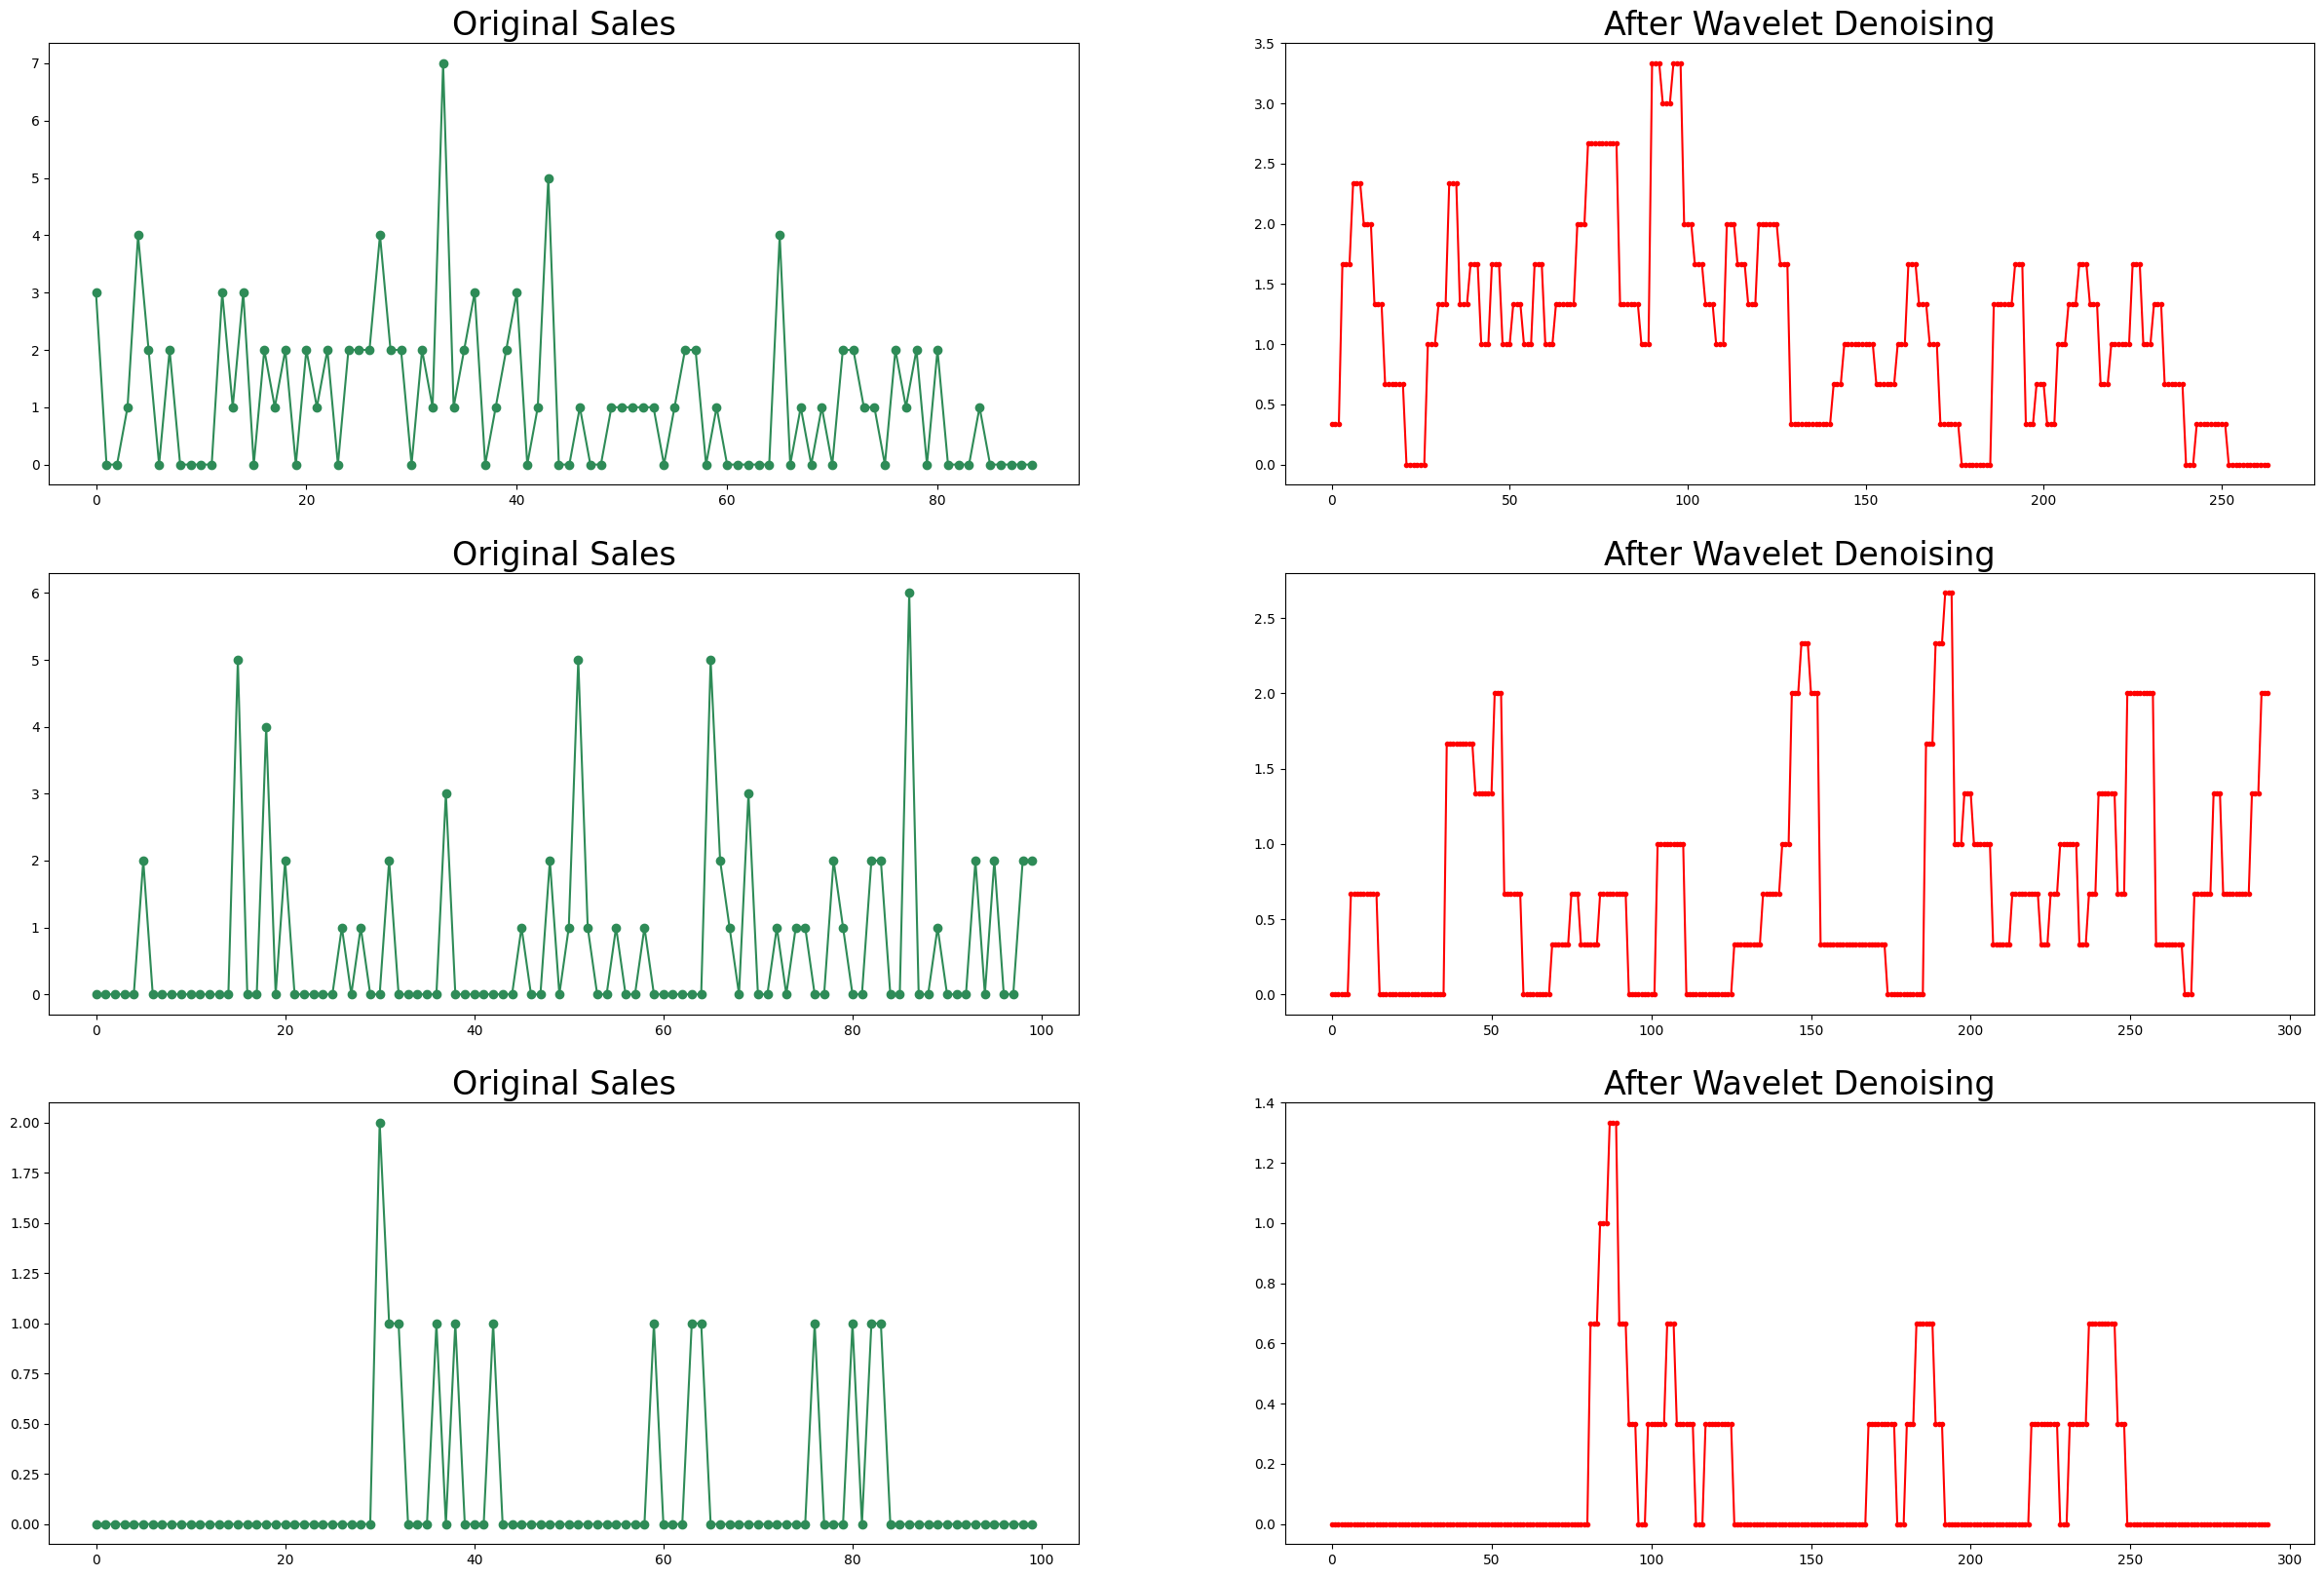

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

ax[0, 0].plot(x_1, color='seagreen', marker='o') 
ax[0, 0].set_title('Original Sales', fontsize=24)
ax[0, 1].plot(y_a1, color='red', marker='.') 
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[1, 0].plot(x_2, color='seagreen', marker='o') 
ax[1, 0].set_title('Original Sales', fontsize=24)
ax[1, 1].plot(y_a2, color='red', marker='.') 
ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[2, 0].plot(x_3, color='seagreen', marker='o') 
ax[2, 0].set_title('Original Sales', fontsize=24)
ax[2, 1].plot(y_a3, color='red', marker='.') 
ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)

plt.show()

## Stores and States

### Rolling Average Price vs. Time for each store

In [13]:
past_sales = sales_train_val.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

store_list = selling_prices['store_id'].unique()
means = []
fig = go.Figure()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per store)")

In the above graph, I have plotted rolling sales across all stores in the dataset. Almost every sales curve has "linear oscillation" trend at the macroscopic level. Basically, the sales oscillate like a sine wave about a certain mean value, but this mean value has an upward linear trend. This implies that the sales are oscillating at a higher and higher level every few months.

This trend is reminiscent of the **business cycle**, where economies have short-term oscillatory fluctuations but grow linearly in the long run. Maybe, such small-scale trends at the level of stores add up to decide trends we see at the macroeconomic level. Below is an illustration of the macroeconomic business cycle:

In [14]:
fig = go.Figure()

for i, s in enumerate(store_list):
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Store name ")

The above plot compares the sales distribution for each store in the dataset. The stores in California seem to have the highest variance in sales, which might indicate that some places in California grow significantly faster than others, i.e. there is development disparity. On the other hand, the Wisconsin and Texas sales seem to be quite consistent among themselves, without much variance. This indicates that development might be more uniform in these states. Moreover, the California stores also seem to have the highest overall mean sales.

In [15]:
df = pd.DataFrame(np.transpose([means, store_list]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name")

From the above graph, we can see the same trends: California stores have the highest variance and mean sales among all the stores in the dataset.

### Rolling Average Price vs. Time (CA)

In [16]:
greens = ["mediumaquamarine", "mediumseagreen", "seagreen", "green"]
store_list = selling_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "ca" in s or "CA" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=greens[i])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (California)")

In the above graph, we can see the large disparity in sales among California stores. The sales curves almost never intersect each other. This may indicate that there are certain "hubs" of development in California which do not change over time. And other areas always remain behind these "hubs". The average sales in descending order are <code>CA_3, CA_1, CA_2, CA_4</code>. The store <code>CA_3</code> has maximum sales while the store <code>CA_4</code> has minimum sales. 

In [17]:
fig = go.Figure()

for i, s in enumerate(store_list):
    if "ca" in s or "CA" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s, marker=dict(color=greens[i])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Store name (California)")

In [18]:
df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name", color_continuous_scale=greens)


fig = go.Figure(data=[
    go.Bar(name='', x=stores, y=means, marker={'color' : greens})])

fig.update_layout(title="Mean sales vs. Store name (California)", yaxis=dict(title="Mean sales"), xaxis=dict(title="Store name"))
fig.update_layout(barmode='group')
fig.show()

In the above plots, we can see the same relationship. The store <code>CA_3</code> has maximum sales while the store <code>CA_4</code> has minimum sales.


### Rolling Average Price vs. Time (WI)

In [19]:
purples = ["thistle", "violet", "purple", "indigo"]
store_list = selling_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "wi" in s or "WI" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=purples[i%len(purples)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (Wisconsin)")

In the above graph, we can see a very low disparity in sales among Wisconsin stores. The sales curves intersect each other very often. This may indicate that most parts of Wisconsin have a similar "development curve" and that there is a greater equity in development across the state. There are no specific "hotspots" or "hubs" of development. The average sales in descending order are <code>WI_2, WI_3, WI_1</code>. The store <code>WI_2</code> has maximum sales while the store <code>WI_1</code> has minimum sales. 

In [20]:
fig = go.Figure()

for i, s in enumerate(store_list):
    if "wi" in s or "WI" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s, marker=dict(color=purples[i%len(purples)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Store name (Wisconsin)")

In [21]:
df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name", color_continuous_scale=greens)


fig = go.Figure(data=[
    go.Bar(name='', x=stores, y=means, marker={'color' : purples})])

fig.update_layout(title="Mean sales vs. Store name (Wisconsin)", yaxis=dict(title="Mean sales"), xaxis=dict(title="Store name"))
fig.update_layout(barmode='group')
fig.show()

### Rolling Average Price vs. Time (TX)

In [22]:
blues = ["skyblue", "dodgerblue", "darkblue"]
store_list = selling_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "tx" in s or "TX" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=blues[i%len(blues)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (Texas)")

In the above graph, we can once again see that a very low disparity in sales among Texas stores. The sales curves intersect each other often, albeit not as often as in Wisconsin. This might once again indicate that most parts of Texas have a similar "development curve" and that there is a greater equity in development across the state. The variance here is higher than in Wisconsin though, so there might be "hubs" of development in Texas as well, but not as pronounced as in California. The average sales in descending order are <code>TX_2, TX_3, TX_1</code>. The store <code>TX_2</code> has maximum sales while the store <code>TX_1</code> has minimum sales.

In [23]:
fig = go.Figure()

for i, s in enumerate(store_list):
    if "tx" in s or "TX" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s, marker=dict(color=blues[i%len(blues)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Store name (Texas)")

In [24]:
df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name", color_continuous_scale=greens)


fig = go.Figure(data=[
    go.Bar(name='', x=stores, y=means, marker={'color' : blues})])

fig.update_layout(title="Mean sales vs. Store name (Texas)", yaxis=dict(title="Mean sales"), xaxis=dict(title="Store name"))
fig.update_layout(barmode='group')
fig.show()

In the above plots, we can see the same relationship. The store <code>TX_2</code> has maximum sales while the store <code>TX_1</code> has minimum sales. 

## Modeling <a id="3"></a>

Now, I will demonstrate how sales can be forecasted using various methods, namely: **naive approach, moving average, exponential smoothing, and ARIMA**

### Train/Val split <a id="3.1"></a>

First, we need to create miniature training and validation sets to train and validate our models. I will use the last 30 days' sales as the validation data and the sales of the 70 days before that as the training data. We need to predict the sales in the validation data using the sales in the training data.

In [25]:
train_dataset = sales_train_val[d_cols[-100:-30]]
val_dataset = sales_train_val[d_cols[-30:]]

Below are the sales from three sample data points. I will use these samples to demonstrate the working of the models.

In [26]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

### Moving average <a id="3.3"></a>

The **moving average** method is more complex than the naive approach. It calculates the mean sales over the previous 30 (or any other number)  days and forecasts that as the next day's sales. This method takes the previous 30 timesteps into consideration, and is therefore less prone to short term fluctuations than the naive approach. The model can be summarized as follows:

<img src="https://i.imgur.com/5uJvt7H.png" width="200px">

In the above equation, *y<sub>t+1</sub>* is tomorrow's sales. On the right hand side, all the sales for the previous 30 days are added up and divided by 30 to find the average. This forms the model's prediction, *y<sub>t+1</sub>*. Now let us see how this new model performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [27]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_avg = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [28]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Moving average")
fig.show()

### Exponential smoothing <a id="3.5"></a>

The **exponential smoothing** method uses a different type of smoothing which differs from average smoothing. The previous time steps are exponentially weighted and added up to generate the forecast. The weights decay as we move further backwards in time. The model can be summarized as follows:

<img src="https://i.imgur.com/IqqjOFc.png" width="520px">
<img src="https://i.imgur.com/GiyHyZf.png" width="255px">

In the above equations, $\alpha$ is the smoothing parameter. The forecast *y<sub>t+1</sub>* is a weighted average of all the observations in the series *y<sub>1</sub>, … ,y<sub>t</sub>*. The rate at which the weights decay is controlled by the parameter *α*. This method gives different weightage to different time steps, instead of giving the same weightage to all time steps (like the moving average method). This ensures that recent sales data is given more importance than old sales data while making the forecast. Now let us see how this new smoothing method performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [29]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    fit = ExponentialSmoothing(row, seasonal_periods=3).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_exponential = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Exponential smoothing")
fig.show()

We can see that exponential smoothing is generating a horizontal line every time. This is because it gives very low weightage to faraway time steps, causing the predictions to flatten out or remain constant. However, it is able to predict the mean sales with excellent accuracy.

### ARIMA <a id="3.6"></a>

**ARIMA** stands for **A**uto **R**egressive **I**ntegrated **M**oving **A**verage. While exponential smoothing models were based on a description of trend and seasonality in data, ARIMA models aim to describe the correlations in the time series.

In [31]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0, 1, 1, 7)).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_arima = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="ARIMA")
fig.show()

### Loss for each model

In [33]:
error = [error_avg, error_exponential, error_arima]
names = ["Moving average","Exponential smoothing", "ARIMA"]
df = pd.DataFrame(np.transpose([error, names]))
df.columns = ["RMSE Loss", "Model"]
px.bar(df, y="RMSE Loss", x="Model", color="Model", title="RMSE Loss vs. Model")